# Supervised classification Workflow Example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kshitijrajsharma/nickyspatial/blob/refs/heads/master/docs/examples/supervised_classification.ipynb)

This example explains how to perform supervised classification.

## Setup & Imports

We begin by importing the required modules and setting up the environment. & Download the sample quickbird satellite image for our module

In [1]:
# ! pip install nickyspatial

import os
os.chdir("/Users/rabinatwayana/Rabina/CDE II/application development/nickyspatial/")
os.getcwd()
! pip install -e .

Obtaining file:///Users/rabinatwayana/Rabina/CDE%20II/application%20development/nickyspatial
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for nickyspatial (pyproject.toml) ... done
  Created wheel for nickyspatial: filename=nickyspatial-0.1.1-py3-none-any.whl size=4169 sha256=9a3be36f0a17f5f278e29eca9d7d1e7ea3f8d80022ee1a8a5860571d269c0252
  Stored in directory: /private/var/folders/z7/dwc0g9dx10n413p0gzrtz1lh0000gn/T/pip-ephem-wheel-cache-jrik8fq8/wheels/ec/a8/4d/b8dca7ce44a31ad6568dd202bbf8e97254b97c0e296965da10
Successfully built nickyspatial
  Attempting uninstall: nickyspatial
    Found existing installation: nickyspatial 0.1.1
    Uninstalling nickyspatial-0.1.1:
      Successfully uninstalled nickyspatial-0.1.1


In [2]:
import os
import requests
import matplotlib.pyplot as plt
import pandas as pd

from nickyspatial import (
    LayerManager,
    MultiResolutionSegmentation,
    RuleSet,
    attach_ndvi,
    attach_shape_metrics,
    attach_spectral_indices,
    layer_to_raster,
    layer_to_vector,
    plot_classification,
    plot_sample,
    plot_layer,
    plot_layer_interactive,
    read_raster,
    MergeRuleSet,
    EnclosedByRuleSet,
    TouchedByRuleSet,
    SupervisedClassifier,
    Layer  
)

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)


data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

raster_path = os.path.join(data_dir, "sample.tif")


if not os.path.exists(raster_path):
    url = "https://github.com/kshitijrajsharma/nickyspatial/raw/refs/heads/master/data/sample.tif"
    print(f"Downloading sample raster from {url}...")
    response = requests.get(url)
    response.raise_for_status()  # Ensure the download succeeded
    with open(raster_path, "wb") as f:
        f.write(response.content)
    print(f"Downloaded sample raster to {raster_path}")
else:
    print(f"Using existing raster at: {raster_path}")

Using existing raster at: data/sample.tif


## Reading the Raster

We now read the raster data and print some basic information about the image.

In [3]:
image_data, transform, crs = read_raster(raster_path)
print(f"Image dimensions: {image_data.shape}")
print(f"Coordinate system: {crs}")

Image dimensions: (4, 877, 1164)
Coordinate system: EPSG:32654


## Performing Segmentation

Here we perform multi-resolution segmentation. A `LayerManager` is used to keep track of all layers created in the process. nickyspatial packages uses a layer object which is an underlying vector segmentation tied up to the raster , similar concept as layer in ecognition

In [4]:
manager = LayerManager()

segmenter = MultiResolutionSegmentation(scale=40, compactness=0.5)
segmentation_layer = segmenter.execute(
    image_data,
    transform,
    crs,
    layer_manager=manager,
    layer_name="Base_Segmentation",
)

print("Segmentation layer created:")
print(segmentation_layer)

Number of segments: 638
Segmentation layer created:
Layer 'Base_Segmentation' (type: segmentation, parent: None, objects: 635)


## Visualizing Segmentation

We utilize the built-in plotting function to visualize the segmentation. The image will be displayed inline.

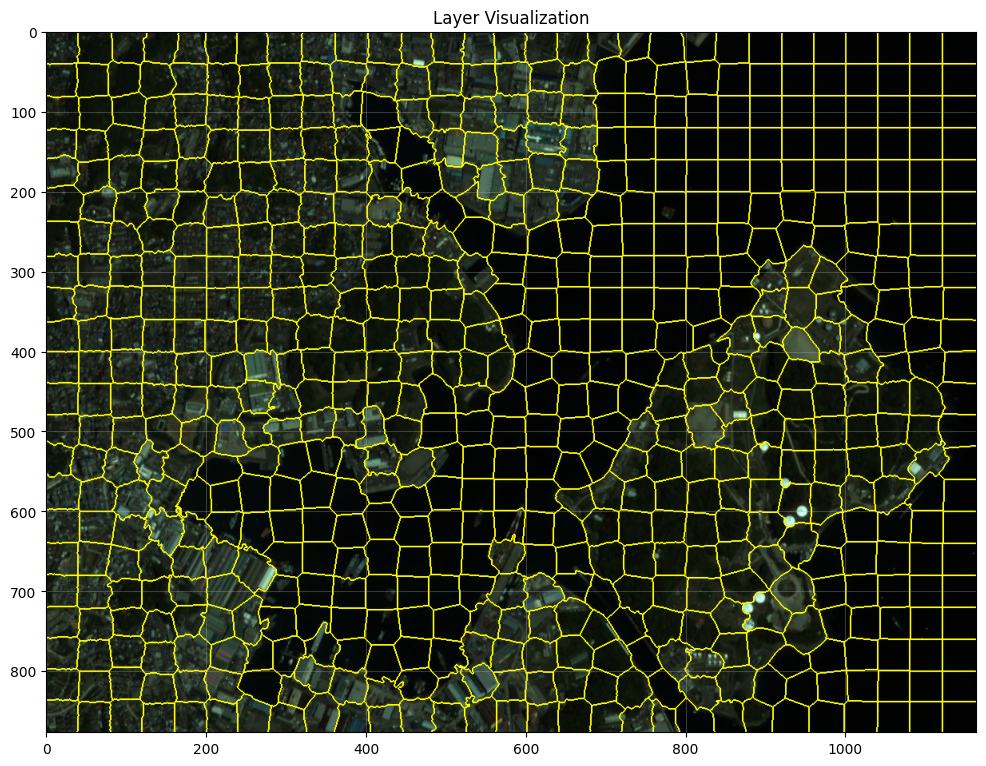

In [5]:
plt.close("all")
%matplotlib inline
fig1 = plot_layer(layer=segmentation_layer, image_data=image_data, rgb_bands=(2, 1, 0), show_boundaries=True)
plt.show()

fig1.savefig(os.path.join(output_dir, "1_segmentation.png"))

## Adding NDVI feature

In [6]:
segmentation_layer.attach_function(
    attach_ndvi,
    name="ndvi_stats",
    nir_column="band_4_mean",
    red_column="band_3_mean",
    output_column="NDVI",
)
segmentation_layer.attach_function(attach_shape_metrics, name="shape_metrics")

## Sample data collection

We use the matplotlib widget to plot the interactive map in notebook to collect the sample for supervised classification. Click on the segments in the map, and segmet id will be displayed in map title.

Output()

Output()

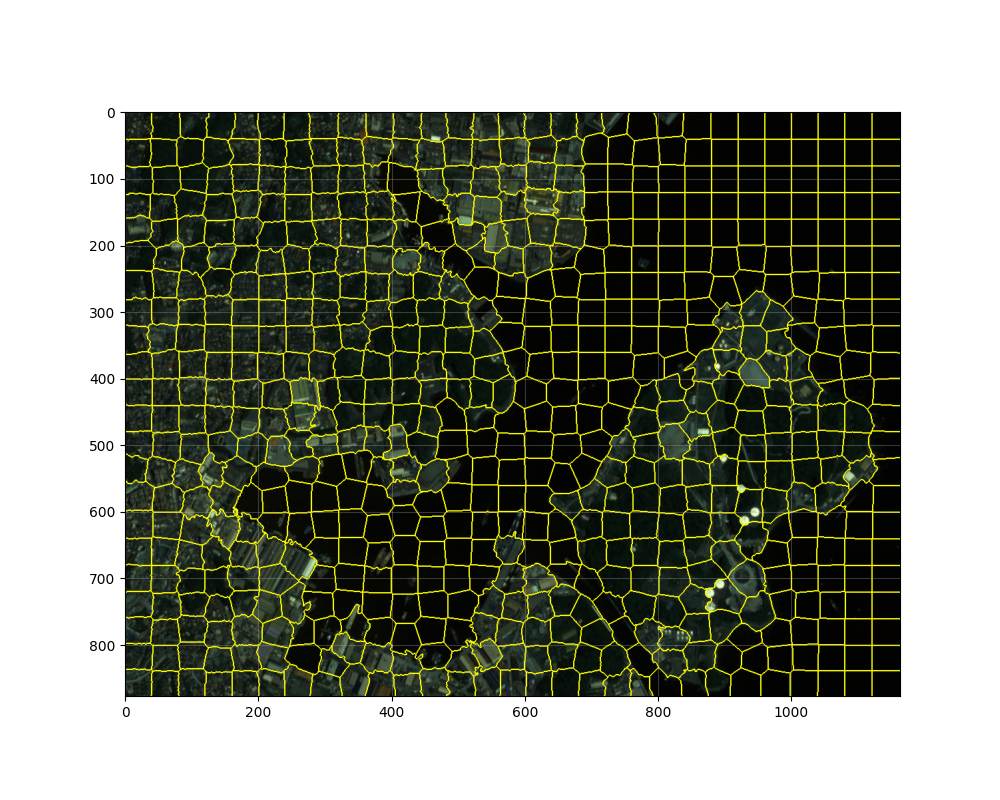

In [16]:
%matplotlib widget
plot_layer_interactive(layer=segmentation_layer,image_data=image_data,figsize=(10,8))

In [8]:
# Sample Data for Classification
# This section defines the sample data used for segment classification. 
# Each class is associated with a list of segment IDs and a specific color for visualization.
samples={
    "Water": [41,134,246,491],
    "built-up": [12,499,290,484],
    "vegetation": [36,143,239,588,371],
}

classes_color= {
    "Water": "#3437c2",
    "built-up":"#de1421",
    "vegetation": "#0f6b2f"
}



## Sample Data Visualization

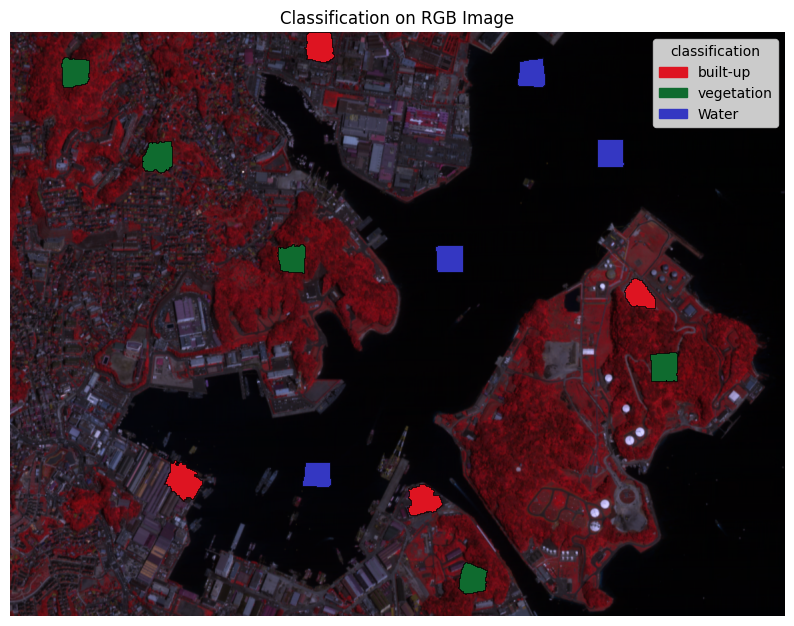

In [9]:
plt.close("all")
%matplotlib inline
sample_objects = segmentation_layer.objects.copy()
sample_objects["classification"] = None

for class_name in samples.keys():
    sample_objects.loc[sample_objects["segment_id"].isin(samples[class_name]), "classification"] = class_name

# Step 3: Wrap the modified GeoDataFrame back into a Layer
sample_layer = Layer(name="Sample Classification", type="classification")
sample_layer.objects = sample_objects

fig = plot_sample(
    sample_layer,
    image_data=image_data,          
    rgb_bands=(3,2,1),
    transform=transform,          
    class_field="classification",
    class_color=classes_color,
    figsize=(10,8)

)
plt.show()

In [10]:
# To get the columns/features name in the layer
segmentation_layer.objects.columns

Index(['segment_id', 'area_pixels', 'area_units', 'geometry', 'band_1_mean',
       'band_1_std', 'band_1_min', 'band_1_max', 'band_1_median',
       'band_2_mean', 'band_2_std', 'band_2_min', 'band_2_max',
       'band_2_median', 'band_3_mean', 'band_3_std', 'band_3_min',
       'band_3_max', 'band_3_median', 'band_4_mean', 'band_4_std',
       'band_4_min', 'band_4_max', 'band_4_median', 'NDVI', 'perimeter',
       'shape_index', 'compactness'],
      dtype='object')

## Supervised Classification using Random Forest Classifier

OOB SCORE 0.9230769230769231


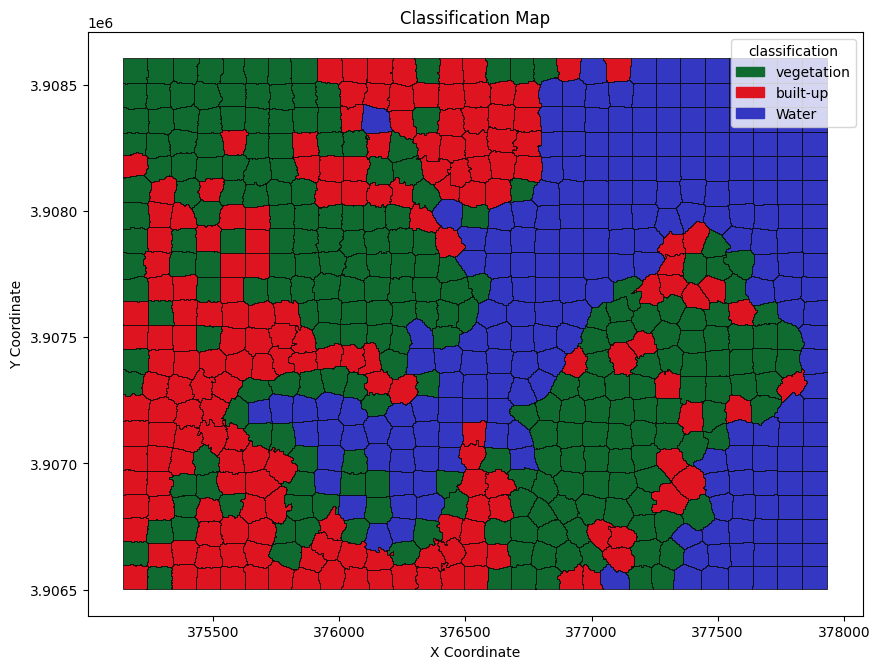

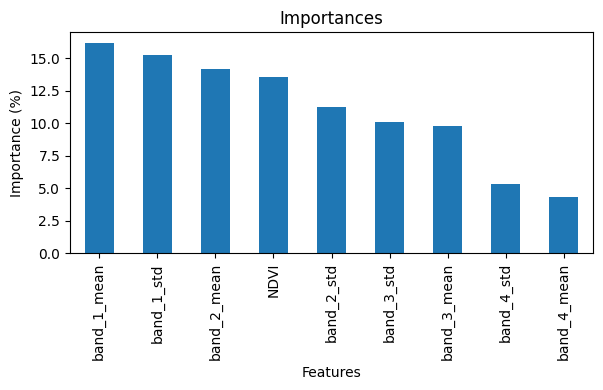

In [11]:
plt.close("all")
%matplotlib inline
params={"n_estimators":100, 
        "oob_score":True, 
        "random_state":42,
        }
features=['band_1_mean','band_1_std', 'band_2_mean', 'band_2_std', 'band_3_mean', 'band_3_std',  'band_4_mean', 'band_4_std','NDVI']

RF_classification=SupervisedClassifier(name="RF Classification", classifier_type="Random Forest", classifier_params=params)
RF_classification_layer, accuracy, feature_importances = RF_classification.execute(segmentation_layer,samples=samples,layer_manager=manager,layer_name="RF Classification",features=features)
print("OOB SCORE",accuracy)

# Plot classification result
fig4 = plot_classification(RF_classification_layer, class_field="classification", class_color=classes_color,figsize=(10,8))
# plt.show()

# Plot feature importance graph
ig, ax = plt.subplots(figsize=(6, 4))
feature_importances.plot.bar(ax=ax)
ax.set_title("Importances")
ax.set_xlabel("Features")
ax.set_ylabel("Importance (%)")
plt.tight_layout()
plt.show()


## Applying merge rule

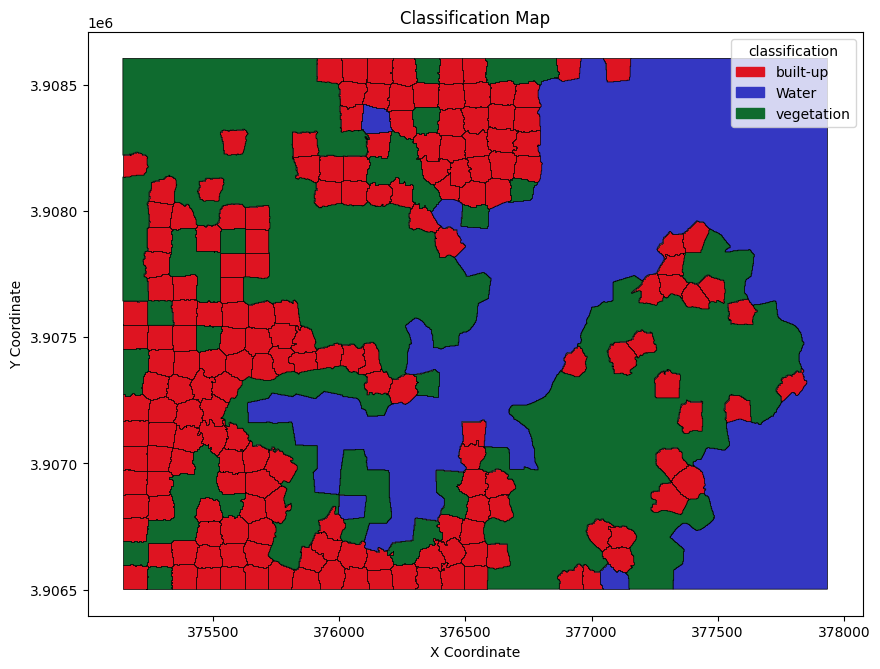

In [12]:
plt.close("all")
%matplotlib inline
merger = MergeRuleSet("MergeByVegAndType")
class_value=["Water","vegetation"]
merged_layer = merger.execute(
    source_layer=RF_classification_layer,
    class_column_name="classification",
    class_value=class_value,
    layer_manager=manager,
    layer_name="Merged RF Classification",
)
fig4 = plot_classification(merged_layer, class_field="classification", class_color=classes_color,figsize=(10,8))


## Applying Enclosed_by rule

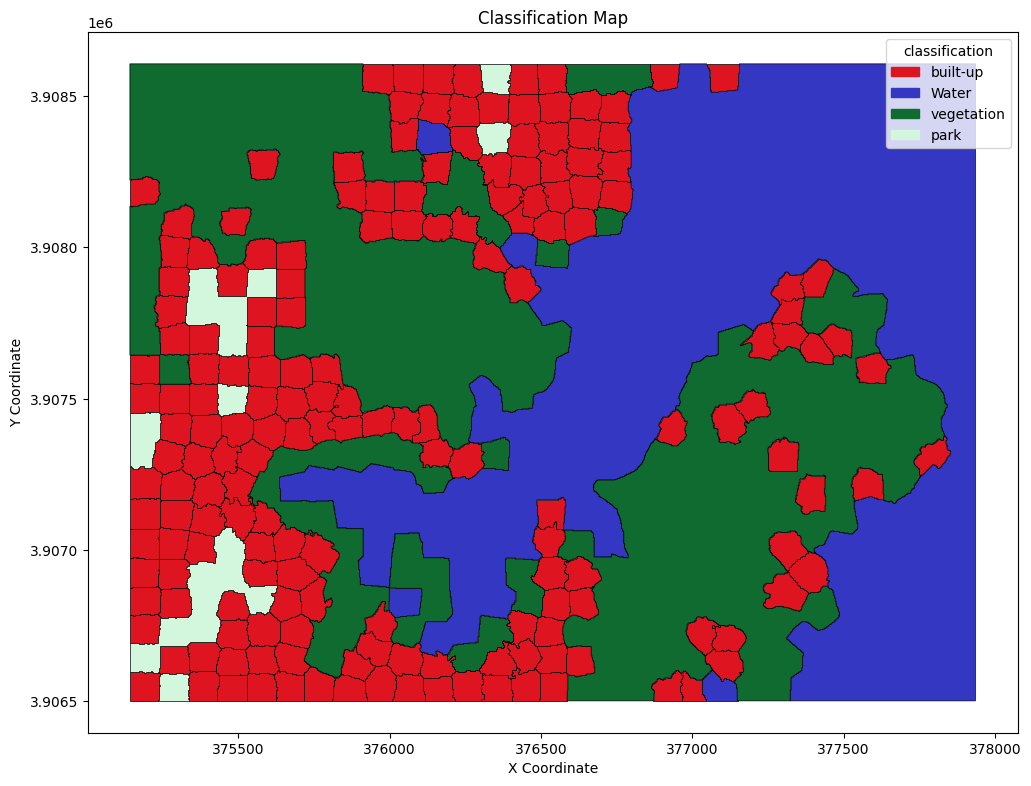

In [13]:
plt.close("all")
%matplotlib inline
enclosed_by_rule = EnclosedByRuleSet()
enclosed_by_layer = enclosed_by_rule.execute(
    source_layer=merged_layer,
    class_column_name="classification",
    class_value_a="vegetation",
    class_value_b="built-up",
    new_class_name="park",
    layer_manager=manager,
    layer_name="enclosed_by_layer",
)
classes_color["park"]="#d2f7dc"
fig4 = plot_classification(enclosed_by_layer, class_field="classification", class_color=classes_color)

## Applying Touched_by rule

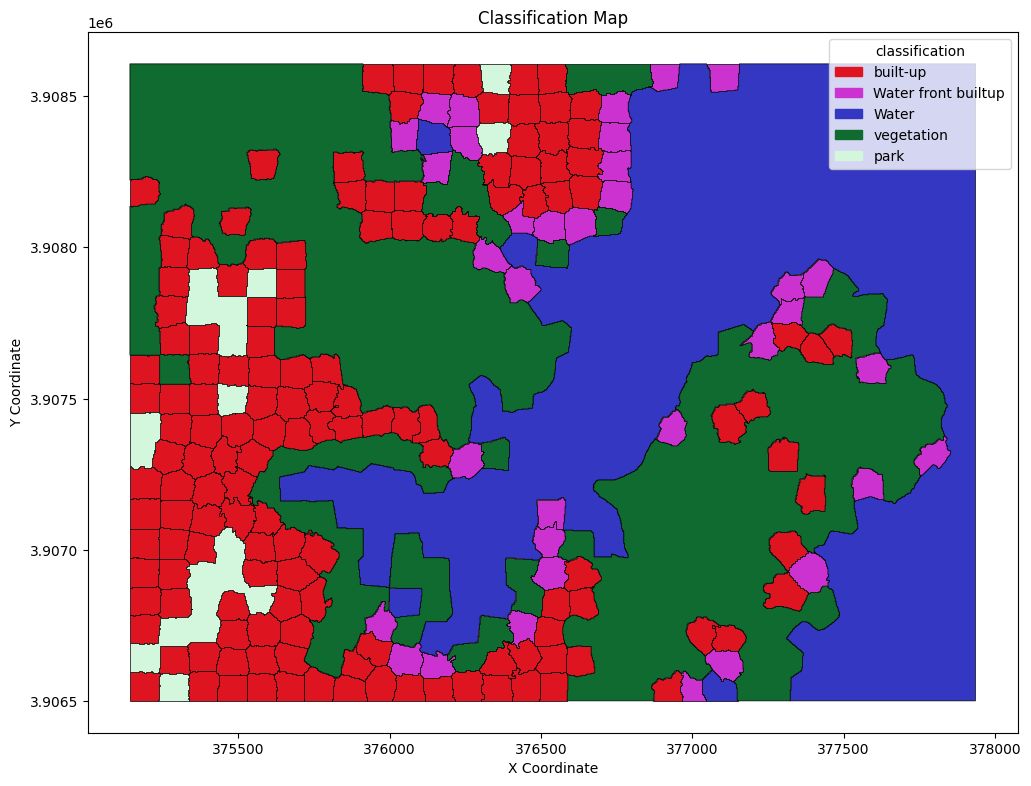

In [14]:
plt.close("all")
%matplotlib inline
touched_by_rule = TouchedByRuleSet()
touched_by_layer = touched_by_rule.execute(
    source_layer=enclosed_by_layer,
    class_column_name="classification",
    class_value_a="built-up",
    class_value_b="Water",
    new_class_name="Water front builtup",
    layer_manager=manager,
    layer_name="touched_by_layer",
)
classes_color["Water front builtup"]="#cc32cf"
fig4 = plot_classification(touched_by_layer, class_field="classification", class_color=classes_color)

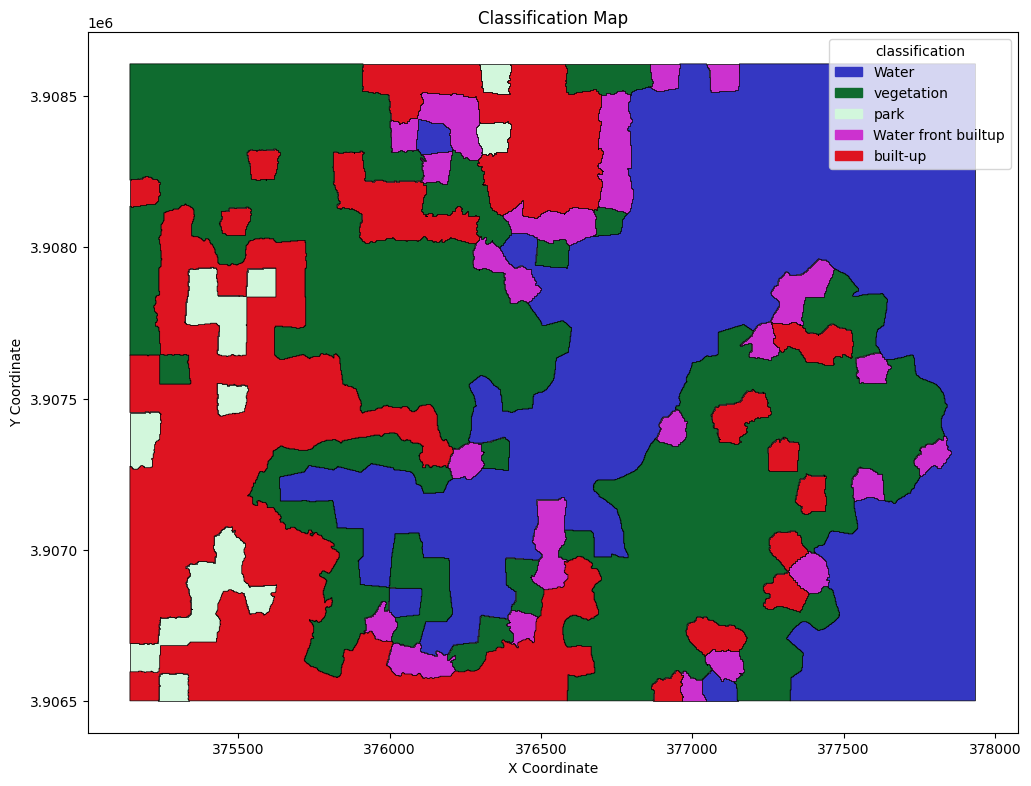

In [15]:
# Applying merge rule 
plt.close("all")
%matplotlib inline
merge_rule = MergeRuleSet("MergeByVegAndType")
merged_layer2 = merger.execute(
    source_layer=touched_by_layer,
    class_column_name="classification",
    class_value=["Water front builtup","built-up"],
    layer_manager=manager,
    layer_name="Merged RF Classification 2",
)
fig4 = plot_classification(merged_layer2, class_field="classification", class_color=classes_color)